<a href="https://colab.research.google.com/github/abyanjan/Face-Emotion-Classification-Detection/blob/master/Face_emotions_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FACE EMOTION CALSSIFICATION WITH TENSORFLOW

In [1]:
!pip install -q livelossplot

In [2]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

## DATA

The dataset used is the FER-13 dataset availabel at [Kaggle](https://www.kaggle.com/msambare/fer2013)

- The data consists of 48x48 pixel grayscale images of faces.
- The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [2]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip the files
!unzip '/content/drive/MyDrive/Computer vision/Face Emotion Recognition/archive.zip' -d /content/Dataset

In [4]:
# Listing Number of Labels and images in Each Labels for Train and Test data set
for data in os.listdir('Dataset'):
  print(f"==={data}=====")
  for label in os.listdir(os.path.join('Dataset', data)):
    no_images = len(os.listdir(os.path.join('Dataset',data, label)))
    print(f"{label}: {no_images}")

===test=====
neutral: 1233
surprise: 831
fear: 1024
disgust: 111
happy: 1774
angry: 958
sad: 1247
===train=====
neutral: 4965
surprise: 3171
fear: 4097
disgust: 436
happy: 7215
angry: 3995
sad: 4830


In [5]:
# get random 3 images from each labels in train data
from glob import glob

vis_images = []
vis_labels = []
for label in os.listdir('Dataset/train'):
  image_list = glob(os.path.join('Dataset/train',label,'*.jpg'))
  select_image = np.random.choice(image_list,3).tolist()
  vis_images.extend(select_image)
  vis_labels.extend([label]*3)

In [6]:
#shape of image
img = cv2.imread(vis_images[0])
img.shape

(48, 48, 3)

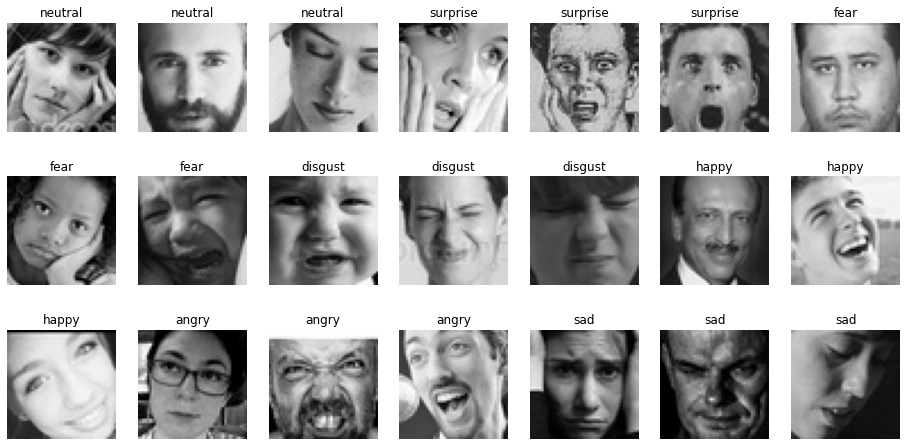

In [7]:
# Visualizing images
fig, ax = plt.subplots(nrows=3, ncols=7, figsize=(16,8))
ax = ax.ravel()
for i in range(len(ax)):
  img = cv2.imread(vis_images[i])
  #img = cv2.resize(img, (300, 300)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax[i].imshow(img)
  ax[i].set_title(vis_labels[i])
  ax[i].axis('off')

**Data Generators**

In [3]:
# Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# train data generator
train_data_gen = ImageDataGenerator(horizontal_flip = True, 
                                   rescale = 1./255
                                   )

# test data generator
test_data_gen = ImageDataGenerator( rescale = 1./255 )

In [21]:
# reading data with the generators
train_data = train_data_gen.flow_from_directory(directory='Dataset/train',
                                                target_size = (48,48), batch_size = 32,
                                                class_mode = 'categorical', 
                                                shuffle = True,  
                                                color_mode = 'grayscale', seed =99)

Found 28709 images belonging to 7 classes.


In [22]:
test_data = test_data_gen.flow_from_directory(directory='Dataset/test',
                                                target_size = (48,48), batch_size = 32,
                                                class_mode = 'categorical',
                                                shuffle = False,
                                                color_mode = 'grayscale', seed =99)

Found 7178 images belonging to 7 classes.


In [7]:
next(train_data)[0][0].shape

(48, 48, 1)

## Modeling

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Dense, Flatten

In [23]:
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 4
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(7, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [24]:
# compile the model
BATCH_SIZE = 32
EPOCHS =50

STEPS_PER_EPOCH = train_data.n // BATCH_SIZE
VALIDATION_STEPS = test_data.n // BATCH_SIZE


In [25]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from livelossplot import PlotLossesKeras

#logdir = "tensorboard"
#tensorboard = TensorBoard(log_dir = logdir)

model_save = ModelCheckpoint('/content/drive/MyDrive/Computer vision/Face Emotion Recognition/best_weights.h5', 
                             save_best_only = True, 
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_delta=0.001,  
                              patience = 2, min_lr = 1e-6, 
                              mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0.001,
                           patience = 4, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

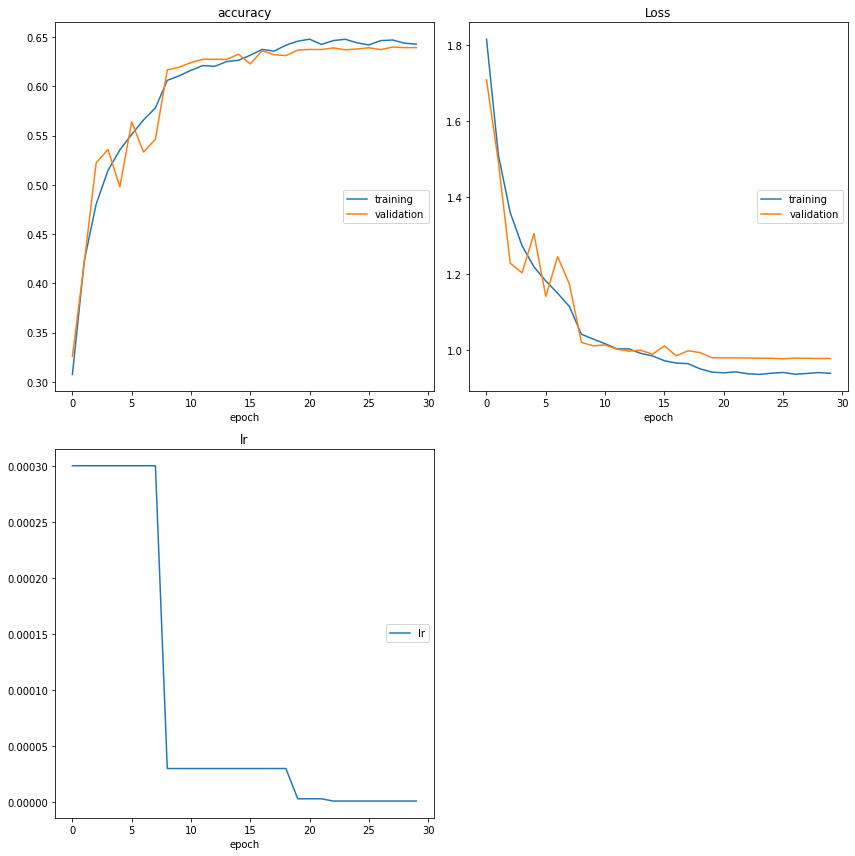

accuracy
	training         	 (min:    0.308, max:    0.648, cur:    0.643)
	validation       	 (min:    0.326, max:    0.640, cur:    0.639)
Loss
	training         	 (min:    0.936, max:    1.815, cur:    0.939)
	validation       	 (min:    0.977, max:    1.708, cur:    0.978)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
Epoch 00030: early stopping


In [27]:
history = model.fit(train_data, validation_data=test_data, 
            steps_per_epoch=STEPS_PER_EPOCH,
            validation_steps=VALIDATION_STEPS,
            epochs=EPOCHS,callbacks =[model_save, reduce_lr, early_stop, PlotLossesKeras()])

In [28]:
# final evaluation on test data
model.evaluate(test_data)

225/225 [==============================] - 2s 11ms/step - loss: 0.9762 - accuracy: 0.6397


[0.9762269258499146, 0.6397325396537781]

In [29]:
# Make predictions
test_pred = model.predict(test_data)

In [30]:
test_pred.shape

(7178, 7)

In [31]:
test_pred

array([[7.34776199e-01, 2.08726805e-02, 6.35772422e-02, ...,
        1.56301092e-02, 7.48591200e-02, 1.71896827e-03],
       [5.53572953e-01, 4.20278264e-03, 1.21613041e-01, ...,
        6.33999333e-02, 9.12420526e-02, 2.95830462e-02],
       [5.38995378e-02, 2.31272308e-03, 1.14005886e-01, ...,
        2.03766301e-02, 7.92736888e-01, 9.81121883e-03],
       ...,
       [8.58107954e-03, 1.18075104e-05, 3.30205001e-02, ...,
        2.06198543e-02, 5.31761767e-03, 9.25427794e-01],
       [2.84603275e-02, 1.31716020e-03, 3.87881398e-02, ...,
        1.11090261e-02, 6.53906353e-03, 9.12827194e-01],
       [8.36295309e-04, 5.04664968e-06, 1.23781925e-02, ...,
        1.69310559e-04, 4.79721020e-05, 9.66606081e-01]], dtype=float32)

In [32]:
# taking the most likely predictions
test_pred_labels = np.argmax(test_pred, axis=1).flatten()
test_pred_labels

array([0, 0, 5, ..., 6, 6, 6])

In [33]:
test_data.labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

**Confusion Matrix**

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

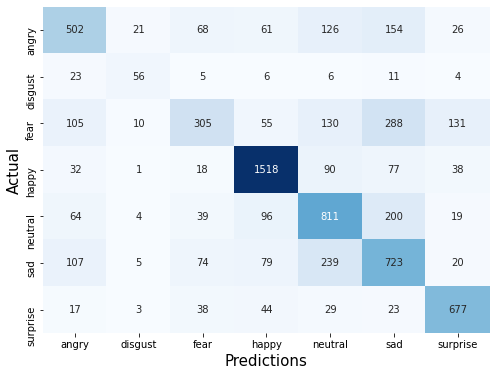

In [36]:
conf_mat = confusion_matrix(y_true=test_data.labels, y_pred=test_pred_labels)
labels = list(test_data.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot = True, cbar=False, cmap='Blues', fmt='.4g', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predictions", size=15)
plt.ylabel("Actual",size=15)
plt.show()

In [37]:
print(classification_report(test_data.labels, test_pred_labels,  target_names=labels))

              precision    recall  f1-score   support

       angry       0.59      0.52      0.56       958
     disgust       0.56      0.50      0.53       111
        fear       0.56      0.30      0.39      1024
       happy       0.82      0.86      0.84      1774
     neutral       0.57      0.66      0.61      1233
         sad       0.49      0.58      0.53      1247
    surprise       0.74      0.81      0.78       831

    accuracy                           0.64      7178
   macro avg       0.62      0.60      0.60      7178
weighted avg       0.64      0.64      0.63      7178

